## MLCS - Final Assignment
24th November 2023

*Rasmus G. K. Christiansen, Bernhard Zosel*

### Imports

*required packages: pandas (v2.0.3) , numpy (v1.25.2), matplotlib (3.7.2), seaborn (0.12.2), scikit-learn (v1.3.0), imbalanced-learn (v0.11.0), xgboost (v2.0.2), keras (v.2.14.0)*

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

2023-11-24 20:23:25.522206: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data Loading

*specify the location of the datasets for both application and botnet traffic*

In [2]:
appl_filenames = ["applicationDNS.csv", "dns_application_2017_1.csv", "dns_application_2017.csv"]
appl_dataset_folder = "datasets/application_data_flow"

bot_filenames = ["init.csv","init2.csv","init3.csv","init4.csv","init5.csv"]
bot_dataset_folder = "datasets/botnet_data_flow"

Load Dataset and Label Malicious and Benign Network Flows

In [3]:
appl_dfs = []
for file in appl_filenames:
    appl_dfs.append(pd.read_csv(f"{appl_dataset_folder}/{file}"))
appl_df = pd.concat(appl_dfs, ignore_index=True)
appl_df['Label'] = 'Benign'
print(f"Number of Benign Flows: {len(appl_df)}")


botnet_dfs = []
for file in bot_filenames:
    botnet_dfs.append(pd.read_csv(f"{bot_dataset_folder}/{file}"))
botnet_df = pd.concat(botnet_dfs, ignore_index=True)

ip_list = ["192.168.50.14","192.168.50.15","192.168.50.16","192.168.50.17","192.168.50.18","192.168.50.30","192.168.50.31", "192.168.50.32","192.168.50.34"]
botnet_df['Label'] = botnet_df['Src IP'].isin(ip_list).apply(lambda x: 'Malicious' if x else 'Normal')
botnet_df = botnet_df[botnet_df['Label']=='Malicious']
print(f"Number of Malicious Flows: {len(botnet_df)}")

df = pd.concat([appl_df, botnet_df], ignore_index=True)

Number of Benign Flows: 76478
Number of Malicious Flows: 539715


### Data Analysis and Visualization

Number of Flows for each Botnet

In [4]:
def print_class_frequencies(df):

    ip_dict = {
        "192.168.50.14":"Zyklon",
        "192.168.50.15":"Blue",
        "192.168.50.16":"Liphyra",
        "192.168.50.17":"Gaudox",
        "192.168.50.18":"Blackout",
        "192.168.50.30":"Citadel",
        "192.168.50.31":"Citadel2", 
        "192.168.50.32":"BlackEnergy",
        "192.168.50.34":"Zeus"
    }
    
    count=0
    for ip in ip_dict.keys():
        entries = df[df["Src IP"]==ip]
        count += len(entries)
    for ip in ip_dict.keys():
        entries = df[df["Src IP"]==ip]
        print(f"{ip} ({ip_dict[ip]}): {len(entries)} ({len(entries)/count * 100:.2f}%)")

print_class_frequencies(df)

192.168.50.14 (Zyklon): 28823 (5.34%)
192.168.50.15 (Blue): 42554 (7.88%)
192.168.50.16 (Liphyra): 17217 (3.19%)
192.168.50.17 (Gaudox): 132013 (24.46%)
192.168.50.18 (Blackout): 37423 (6.93%)
192.168.50.30 (Citadel): 45218 (8.38%)
192.168.50.31 (Citadel2): 132699 (24.59%)
192.168.50.32 (BlackEnergy): 15831 (2.93%)
192.168.50.34 (Zeus): 87937 (16.29%)


In [5]:
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.50.50-192.168.50.88-64344-53-17,192.168.50.50,64344,192.168.50.88,53,17,13/06/2017 03:58:41 AM,3984697,1,2,...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
1,192.168.50.255-192.168.50.19-17500-17500-17,192.168.50.19,17500,192.168.50.255,17500,17,13/06/2017 03:59:59 AM,60015400,2,1,...,0,0.0,0.0,0.0,0.0,30007700.0,11807.269032,30016049.0,29999351.0,Benign
2,192.168.50.51-192.168.50.88-57092-53-17,192.168.50.51,57092,192.168.50.88,53,17,13/06/2017 03:59:46 AM,10000499,4,2,...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
3,192.168.50.51-192.168.50.88-55824-53-17,192.168.50.51,55824,192.168.50.88,53,17,13/06/2017 04:01:04 AM,7998366,4,1,...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
4,192.168.50.51-192.168.50.88-58882-53-17,192.168.50.51,58882,192.168.50.88,53,17,13/06/2017 03:59:37 AM,10000458,2,2,...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign


### Data Preprocessing

In [6]:
# remove nan's and inf's
df = df.replace(np.inf, np.nan)
df = df.dropna()

# drop flow id and information about ip addresses as they would directly give information about origin from botnet
df_X = df.drop(columns=["Label", "Flow ID", "Src IP", "Dst IP", "Src Port","Dst Port", "Timestamp"])
df_y = df["Label"]

In [7]:
# One hot encode the protocol column as this column represents the type of protocol (17=>UDP, 6=>TCP)

df_X = pd.get_dummies(df_X, columns=['Protocol'])
df_X.head()

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_0,Protocol_6,Protocol_17
0,3984697,1,2,37.0,74.0,37.0,37.0,37.0,0.0,37.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
1,60015400,2,1,268.0,134.0,134.0,134.0,134.0,0.0,134.0,...,0.0,0.0,0.0,30007700.0,11807.269032,30016049.0,29999351.0,False,False,True
2,10000499,4,2,168.0,84.0,42.0,42.0,42.0,0.0,42.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
3,7998366,4,1,176.0,44.0,44.0,44.0,44.0,0.0,44.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
4,10000458,2,2,88.0,88.0,44.0,44.0,44.0,0.0,44.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True


In [8]:
# Normalize data (not for decision tree and random forest)
# (note: protocol one hot-encoded columns do not need to be scaled)

scaler = StandardScaler()
df_X_scaled = scaler.fit_transform(df_X[df_X.columns[:-3]])

df_X_scaled = pd.DataFrame(df_X_scaled, columns=df_X.columns[:-3])
df_X_scaled[df_X.columns[-3:]] = df_X[df_X.columns[-3:]]
df_X_scaled.head()

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_0,Protocol_6,Protocol_17
0,-0.197223,-0.178273,0.061675,-0.256793,-0.012647,0.453814,0.466711,0.464425,-0.046834,-0.276854,...,-0.061106,-0.14495,-0.16014,-0.205001,-0.088995,-0.207219,-0.195185,False,False,True
1,2.427070,0.098283,-0.459456,1.086011,-0.006000,3.311558,3.383699,3.373460,-0.046834,0.047440,...,-0.061106,-0.14495,-0.16014,2.993699,-0.085403,2.569671,3.202846,False,False,True
2,0.084537,0.651396,0.061675,0.504711,-0.011539,0.601121,0.617071,0.614375,-0.046834,-0.260138,...,-0.061106,-0.14495,-0.16014,-0.205001,-0.088995,-0.207219,-0.195185,False,False,True
3,-0.009236,0.651396,-0.459456,0.551215,-0.015971,0.660043,0.677215,0.674355,-0.046834,-0.253452,...,-0.061106,-0.14495,-0.16014,-0.205001,-0.088995,-0.207219,-0.195185,False,False,True
4,0.084535,0.098283,0.061675,0.039670,-0.011096,0.660043,0.677215,0.674355,-0.046834,-0.253452,...,-0.061106,-0.14495,-0.16014,-0.205001,-0.088995,-0.207219,-0.195185,False,False,True


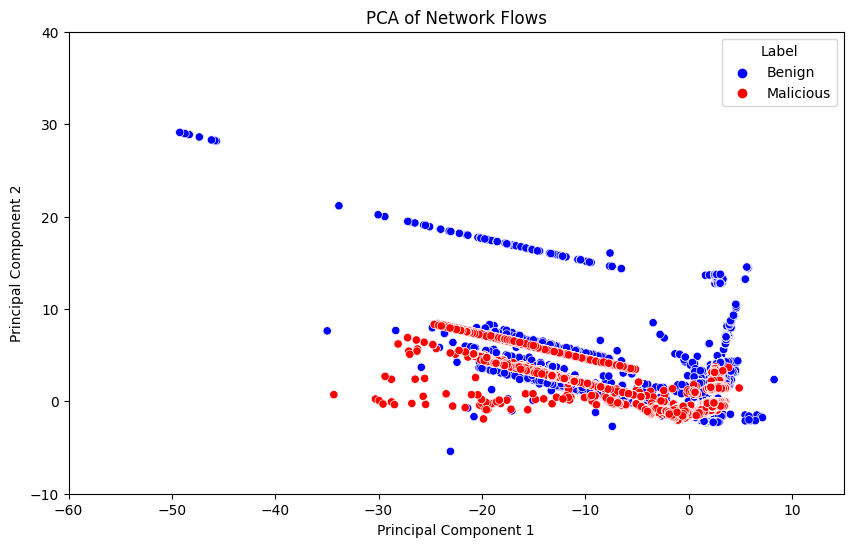

In [9]:
## PCA: visualize the dataset by plotting its two first principal components

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_X_scaled)

# Create a new DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Label']=df['Label']

plt.figure(figsize=(10, 6))
sb.scatterplot(x='PC1', y='PC2', hue='Label', data=pca_df, palette={'Benign': 'blue', 'Malicious': 'red'})
plt.title('PCA of Network Flows')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.xlim((-60,15))
plt.ylim((-10,40))
plt.legend(title='Label', loc='upper right')
plt.show()

### Binary Classification with Grid Search

In [10]:
def perform_grid_search(classifier, param_grid, df_X, df_y, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=test_size)
    
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
    
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_parameters = grid_search.best_params_
    print("Best Parameters:", best_parameters)

    #Cross Validation
    #print(cross_val_score(best_model, df_X, df_y, cv=5))
    
    #Compute train error
    y_train_pred = best_model.predict(X_train)
    print(f"Train Accuracy = {accuracy_score(y_train, y_train_pred)}")
    
    #Compute test error and display metrics
    y_test_pred = best_model.predict(X_test)
    print(f"Test Accuracy = {accuracy_score(y_test, y_test_pred)}")
    
    unique_labels = ["Benign", "Malicious"]
    cm = confusion_matrix(y_test, y_test_pred, labels=unique_labels)    
    plt.figure()
    ax = sb.heatmap(cm, annot=True, cmap="Blues", fmt='d')
    ax.set_title("Test Confusion Matrix\n\n")
    ax.set_xlabel("\nPredicted Values")
    ax.set_ylabel("Actual Values ")
    ax.xaxis.set_ticklabels(unique_labels)
    ax.yaxis.set_ticklabels(unique_labels)
    plt.show()

#### Naive Bayes

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'var_smoothing': 1e-07}
Train Accuracy = 0.9358433700024343
Test Accuracy = 0.9353990630646226


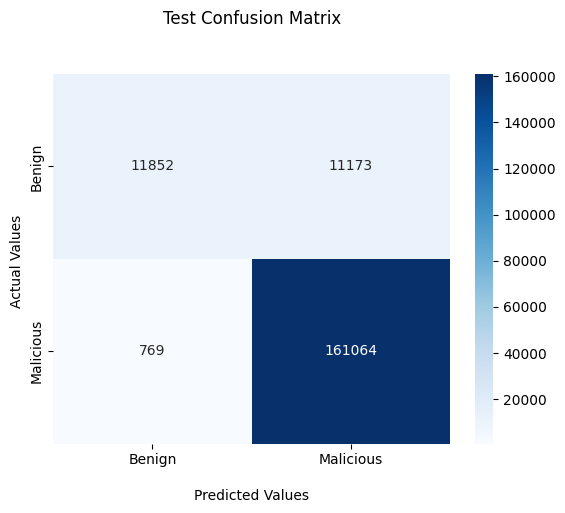

In [11]:
param_grid = {
    'var_smoothing': [1e-9, 1e-7, 1e-5]
}

bayes = GaussianNB()

perform_grid_search(bayes, param_grid, df_X_scaled, df_y)

#### Logistic Regression

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

[CV] END ................................var_smoothing=1e-09; total time=   5.7s
[CV] END ................................C=0.1, max_iter=100; total time=  51.4s
[CV] END ..................................C=1, max_iter=100; total time= 1.0min


/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ................................var_smoothing=1e-09; total time=   5.6s
[CV] END ................................C=0.1, max_iter=100; total time=  52.6s
[CV] END ..................................C=1, max_iter=100; total time= 1.0min


/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................................var_smoothing=1e-07; total time=   5.6s
[CV] END ................................C=0.1, max_iter=100; total time=  55.5s
[CV] END ..................................C=1, max_iter=100; total time=  60.0s


/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

[CV] END ................................var_smoothing=1e-07; total time=   5.7s
[CV] END ...............................C=0.1, max_iter=1000; total time= 3.3min
[CV] END .................................C=10, max_iter=100; total time= 1.0min


/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

[CV] END ................................var_smoothing=1e-07; total time=   5.8s
[CV] END ...............................C=0.1, max_iter=1000; total time= 3.4min
[CV] END .................................C=10, max_iter=500; total time= 4.6min


/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

[CV] END ................................var_smoothing=1e-07; total time=   5.9s
[CV] END ................................C=0.1, max_iter=500; total time= 3.4min
[CV] END .................................C=10, max_iter=100; total time= 1.0min
[CV] END .................................C=10, max_iter=500; total time= 4.6min


/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

[CV] END ................................var_smoothing=1e-09; total time=   5.7s
[CV] END ................................C=0.1, max_iter=500; total time= 3.4min
[CV] END .................................C=10, max_iter=100; total time= 1.1min
[CV] END ................................C=10, max_iter=1000; total time= 6.3min


/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

[CV] END ................................var_smoothing=1e-07; total time=   5.9s
[CV] END ..................................C=1, max_iter=100; total time=  58.1s
[CV] END ..................................C=1, max_iter=500; total time= 4.5min
[CV] END ................................C=10, max_iter=1000; total time= 5.4min


/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................................var_smoothing=1e-05; total time=   5.9s
[CV] END ................................C=0.1, max_iter=100; total time=  44.0s
[CV] END ..................................C=1, max_iter=100; total time=  59.9s
[CV] END ..................................C=1, max_iter=500; total time= 4.5min
[CV] END ................................C=10, max_iter=1000; total time= 4.8min


/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..................................C=1, max_iter=500; total time= 4.6min
[CV] END ................................C=10, max_iter=1000; total time= 4.4min
[CV] END ..................................C=1, max_iter=500; total time= 4.6min
Best Parameters: {'C': 10, 'max_iter': 1000}
Train Accuracy = 0.9748710399109741
Test Accuracy = 0.97493211005204


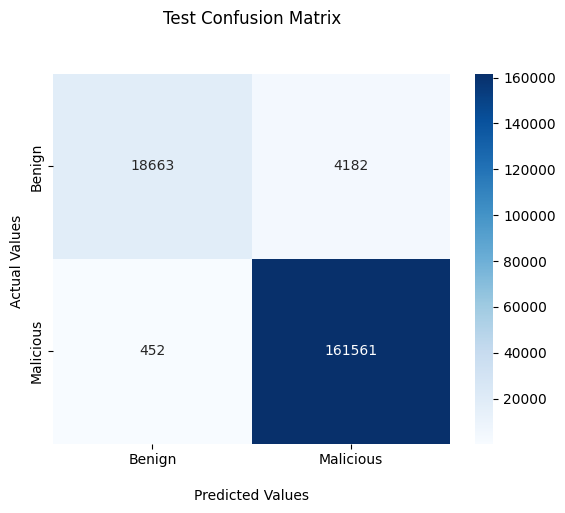

[CV] END ................................var_smoothing=1e-05; total time=   5.9s
[CV] END ................................C=0.1, max_iter=500; total time= 3.3min
[CV] END .................................C=10, max_iter=100; total time= 1.0min
[CV] END .................................C=10, max_iter=500; total time= 4.5min
[CV] END ................................var_smoothing=1e-05; total time=   5.9s
[CV] END ...............................C=0.1, max_iter=1000; total time= 3.3min
[CV] END .................................C=10, max_iter=100; total time= 1.0min
[CV] END .................................C=10, max_iter=500; total time= 4.5min
[CV] END .................................C=10, max_iter=500; total time= 4.6min
[CV] END .................................C=1, max_iter=1000; total time= 7.2min
[CV] END ................................var_smoothing=1e-09; total time=   5.2s
[CV] END ................................C=0.1, max_iter=500; total time= 3.1min
[CV] END ...................

In [13]:
param_grid = {
    'max_iter': [100,500,1000],
    'C': [0.1, 1, 10]
}

log = LogisticRegression()

perform_grid_search(log, param_grid, df_X_scaled, df_y)

#### Decision Tree

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Train Accuracy = 0.9943361888091623
Test Accuracy = 0.9939034285776109


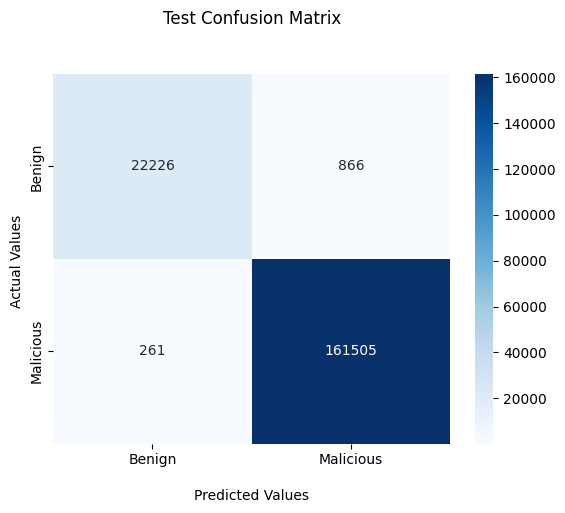

In [16]:
param_grid = {
    'max_depth': [5, 10, 30, 50],
    'min_samples_split': [2, 6],
    'criterion': ['gini','entropy'],
    'min_samples_leaf': [1, 4]
}

dtree = DecisionTreeClassifier()

perform_grid_search(dtree, param_grid, df_X, df_y)

#### Random Forest

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=6; total time=  10.5s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=6; total time=  18.3s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=1, min_samples_split=6; total time=  20.7s
[CV] END criterion=gini, max_depth=50, min_samples_leaf=1, min_samples_split=2; total time=  20.1s
[CV] END criterion=gini, max_depth=50, min_samples_leaf=4, min_samples_split=2; total time=  16.5s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=6; total time=   9.7s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=2; total time=  15.9s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=1, min_samples_split=6; total time=  20.2s
[CV] END criterion=gini, max_depth=50, min_samples_leaf=1, min_samples_split=2; total time=  20.1s
[CV] END criterion=gini, max_depth=50, min_samples

/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=  10.4s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=6; total time=  18.1s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=1, min_samples_split=2; total time=  20.6s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=4, min_samples_split=6; total time=  20.6s
[CV] END criterion=gini, max_depth=50, min_samples_leaf=4, min_samples_split=6; total time=  16.3s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   9.3s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=  15.7s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=6; total time=  15.9s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=4, min_samples_split=2; total time=  19.7s
[CV] END criterion=gini, max_depth=50, min_samples_leaf=1, min_samples_split=6; total time=  20.1s
[CV] END cri

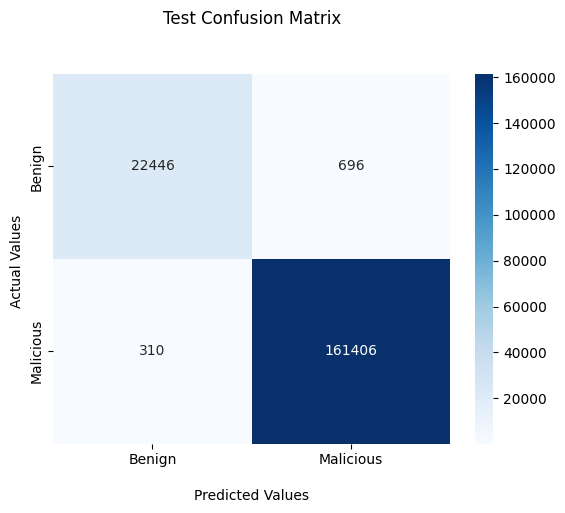

[CV] END ...criterion=entropy, max_depth=5, n_estimators=100; total time= 1.7min
[CV] END ..criterion=entropy, max_depth=10, n_estimators=100; total time= 2.7min
[CV] END ..criterion=entropy, max_depth=30, n_estimators=100; total time= 2.7min
[CV] END ......criterion=gini, max_depth=30, n_estimators=50; total time= 1.9min
[CV] END .....criterion=gini, max_depth=30, n_estimators=200; total time= 7.0min
[CV] END ..criterion=entropy, max_depth=30, n_estimators=100; total time= 2.7min
[CV] END ......criterion=gini, max_depth=30, n_estimators=50; total time= 1.9min
[CV] END .....criterion=gini, max_depth=30, n_estimators=200; total time= 7.1min
[CV] END ..criterion=entropy, max_depth=30, n_estimators=100; total time= 2.7min
[CV] END ......criterion=gini, max_depth=30, n_estimators=50; total time= 1.9min
[CV] END ....criterion=entropy, max_depth=5, n_estimators=50; total time=  54.1s
[CV] END ....criterion=entropy, max_depth=5, n_estimators=50; total time=  55.9s
[CV] END ....criterion=entro

In [17]:
param_grid = {
    'max_depth': [5, 10, 30],
    'n_estimators': [50, 100,200],
    'criterion': ['gini','entropy'],
}


rforest = RandomForestClassifier()

perform_grid_search(rforest, param_grid, df_X, df_y)

#### Multilayer Perceptron

*one hidden layer with 100 neurons and two hidden layers with 50 neurons each have turned out to be most optimal*

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time= 5.2min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time= 9.3min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time= 9.7min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time=12.0min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant; total time=15.1min
Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
Train Accuracy = 0.9894838118863528
Test Accuracy = 0.9898949463912842


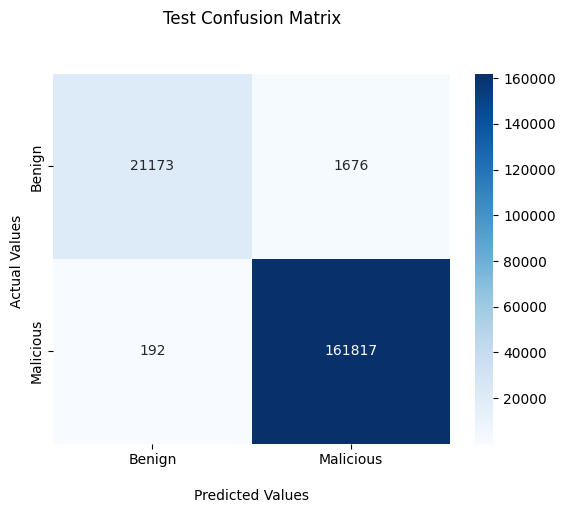

In [18]:
param_grid = {
    'hidden_layer_sizes': [(100,)],
    'activation': ['relu'],
    'alpha': [0.0001],
    'learning_rate': ['constant']
}

mlp1 = MLPClassifier()

perform_grid_search(mlp1, param_grid, df_X_scaled, df_y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time= 6.2min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time= 6.2min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time= 6.7min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time= 7.9min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time= 9.0min
Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive'}
Train Accuracy = 0.9911994157673271
Test Accuracy = 0.9909606292397408


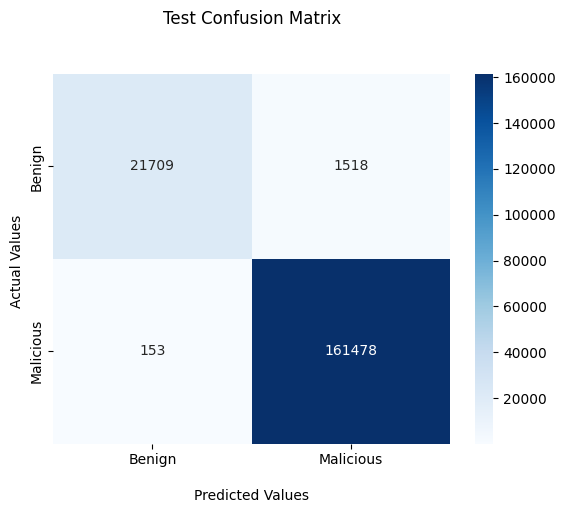

In [19]:
param_grid = {
    'hidden_layer_sizes': [(50, 50)],
    'activation': ['relu'],
    'alpha': [0.001],
    'learning_rate': ['adaptive']
}

mlp2 = MLPClassifier()

perform_grid_search(mlp2, param_grid, df_X_scaled, df_y)

MLP on principal components for better runtime

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time= 4.1min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time= 4.5min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time= 4.6min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time= 8.3min
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive; total time= 8.4min
Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive'}
Train Accuracy = 0.990336977059594
Test Accuracy = 0.990122147810752


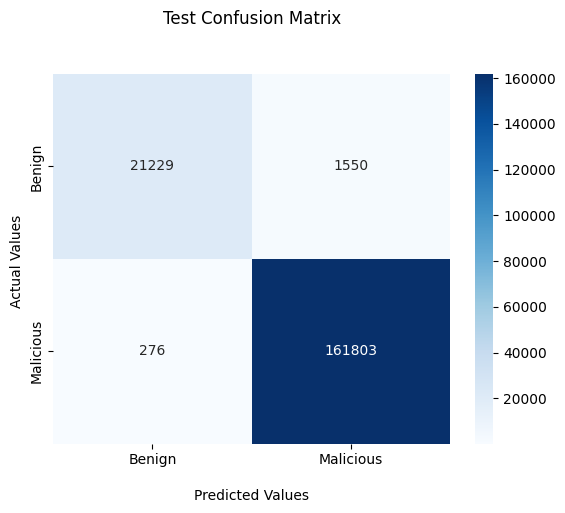

In [20]:
# Create a new DataFrame with the principal components
pca = PCA(n_components=10)
principal_components = pca.fit_transform(df_X_scaled)

param_grid = {
    'hidden_layer_sizes': [(50, 50)],
    'activation': ['relu'],
    'alpha': [0.001],
    'learning_rate': ['adaptive']
}

mlp3 = MLPClassifier()

perform_grid_search(mlp3, param_grid, principal_components, df_y)

### Multi-Class Classifier

#### Data Preprocessing

In [21]:
ip_list = {
    "192.168.50.14":"Zyklon",
    "192.168.50.15":"Blue",
    "192.168.50.16":"Liphyra",
    "192.168.50.17":"Gaudox",
    "192.168.50.18":"Blackout",
    "192.168.50.30":"Citadel",
    "192.168.50.31":"Citadel", 
    "192.168.50.32":"BlackEnergy",
    "192.168.50.34":"Zeus"
}

df_mc = df.copy()

# Modify the 'label' column in the new DataFrame
df_mc['Label'] = df_mc.apply(lambda row: ip_list[row["Src IP"]] if row['Src IP'] in ip_list.keys() else row['Label'], axis=1)


In [22]:
df_mc['Label'].unique()

array(['Benign', 'Zyklon', 'Gaudox', 'Blackout', 'Blue', 'Liphyra',
       'BlackEnergy', 'Citadel', 'Zeus'], dtype=object)

In [24]:
# remove nan's and inf's
df_mc = df_mc.replace(np.inf, np.nan)
df_mc = df_mc.dropna()

# drop flow id and information about ip addresses as they would directly give information about origin from botnet
df_X_mc = df_mc.drop(columns=["Label", "Flow ID", "Src IP", "Dst IP", "Src Port","Dst Port", "Timestamp"])
df_y_mc = df_mc["Label"]

df_X_mc = pd.get_dummies(df_X_mc, columns=['Protocol'])
df_X_mc

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_0,Protocol_6,Protocol_17
0,3984697,1,2,37.0,74.0,37.0,37.0,37.0,0.0,37.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
1,60015400,2,1,268.0,134.0,134.0,134.0,134.0,0.0,134.0,...,0.0,0.0,0.0,30007700.0,11807.269032,30016049.0,29999351.0,False,False,True
2,10000499,4,2,168.0,84.0,42.0,42.0,42.0,0.0,42.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
3,7998366,4,1,176.0,44.0,44.0,44.0,44.0,0.0,44.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
4,10000458,2,2,88.0,88.0,44.0,44.0,44.0,0.0,44.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616188,10000548,2,2,76.0,76.0,38.0,38.0,38.0,0.0,38.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
616189,223,0,2,0.0,152.0,0.0,0.0,0.0,0.0,118.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
616190,10000518,4,2,128.0,64.0,32.0,32.0,32.0,0.0,32.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True
616191,6996279,3,2,114.0,76.0,38.0,38.0,38.0,0.0,38.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,False,False,True


#### Multiclass Grid Search

In [27]:
def perform_mc_grid_search(classifier, param_grid, df_X, df_y, test_size=0.3, smote=False):
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=test_size, random_state=42)
    
    if smote:
        print("Class Frequencies before Upsampling")
        print(y_train.value_counts())
        
        # upsample the minority class (we tried out different numbers without any success)
        smote = SMOTE(k_neighbors=2, sampling_strategy={'Blue': 50000, 'Blackout': 50000, 'Liphyra':50000, 'BlackEnergy':50000, 'Zyklon':50000})
        X_train, y_train = smote.fit_resample(X_train, y_train)

        print("Class Frequencies after Upsampling")
        print(y_train.value_counts())
    
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
    
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_parameters = grid_search.best_params_
    print("Best Parameters:", best_parameters)
    
    #Compute train error
    y_train_pred = best_model.predict(X_train)
    print(f"Train Accuracy = {accuracy_score(y_train, y_train_pred)}")
    
    #Compute test error and display metrics
    y_test_pred = best_model.predict(X_test)
    print(f"Test Accuracy = {accuracy_score(y_test, y_test_pred)}")
    
    unique_labels = ['Benign', 'Zyklon', 'Gaudox', 'Blackout', 'Blue', 'Liphyra','BlackEnergy', 'Citadel', 'Zeus']
    cm = confusion_matrix(y_test, y_test_pred, labels=unique_labels)    
    plt.figure(figsize=(10, 6))
    ax = sb.heatmap(cm, annot=True, cmap="Blues", fmt='d')
    ax.set_title("Test Confusion Matrix\n\n")
    ax.set_xlabel("\nPredicted Values")
    ax.set_ylabel("Actual Values ")
    ax.xaxis.set_ticklabels(unique_labels)
    ax.yaxis.set_ticklabels(unique_labels)
    plt.show()

    print(classification_report(y_test, y_test_pred))

#### Decision Tree (Multi-Class)

*with unbalanced dataset*

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Train Accuracy = 0.8066583977650782
Test Accuracy = 0.8047149704097198


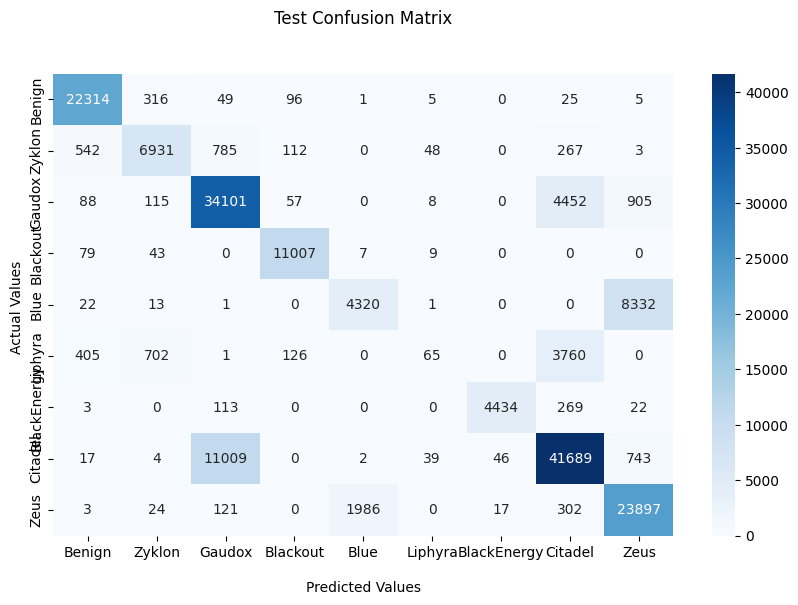

              precision    recall  f1-score   support

      Benign       0.95      0.98      0.96     22811
 BlackEnergy       0.99      0.92      0.95      4841
    Blackout       0.97      0.99      0.98     11145
        Blue       0.68      0.34      0.45     12689
     Citadel       0.82      0.78      0.80     53549
      Gaudox       0.74      0.86      0.79     39726
     Liphyra       0.37      0.01      0.02      5059
        Zeus       0.70      0.91      0.79     26350
      Zyklon       0.85      0.80      0.82      8688

    accuracy                           0.80    184858
   macro avg       0.79      0.73      0.73    184858
weighted avg       0.80      0.80      0.79    184858



In [28]:
param_grid = {
    'max_depth': [5, 10, 30, 50],
    'min_samples_split': [2, 6],
    'criterion': ['gini','entropy'],
    'min_samples_leaf': [1, 4]
}

dtree = DecisionTreeClassifier()

perform_mc_grid_search(dtree, param_grid, df_X_mc, df_y_mc)

*with balanced dataset using SMOTE and sklearn's built-in balancing*

Class Frequencies before Upsampling
Label
Citadel        124368
Gaudox          92287
Zeus            61587
Benign          53667
Blue            29865
Blackout        26278
Zyklon          20135
Liphyra         12158
BlackEnergy     10990
Name: count, dtype: int64
Class Frequencies after Upsampling
Label
Citadel        124368
Gaudox          92287
Zeus            61587
Benign          53667
Blackout        50000
Blue            50000
Liphyra         50000
Zyklon          50000
BlackEnergy     50000
Name: count, dtype: int64
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=2; total time=   9.4s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=6; total time=  14.6s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=1, min_samples_split=2; total time=  20.4s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=4, min_samples_split=6; total time=  19.1s
[CV] END cri

/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=   9.7s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=6; total time=  14.7s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=1, min_samples_split=6; total time=  19.9s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=4, min_samples_split=6; total time=  19.2s
[CV] END criterion=gini, max_depth=50, min_samples_leaf=4, min_samples_split=2; total time=  18.2s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=2; total time=   9.1s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=4, min_samples_split=2; total time=  14.4s
[CV] END criterion=entropy, max_depth=30, min_samples_leaf=1, min_samples_split=6; total time=  20.4s
[CV] END criterion=entropy, max_depth=50, min_samples_leaf=1, min_samples_split=2; total time=  21.0s
[CV] END criterion=entropy, max_depth=50, min_samples_leaf=4, min_samples_split=6; total time=  14.

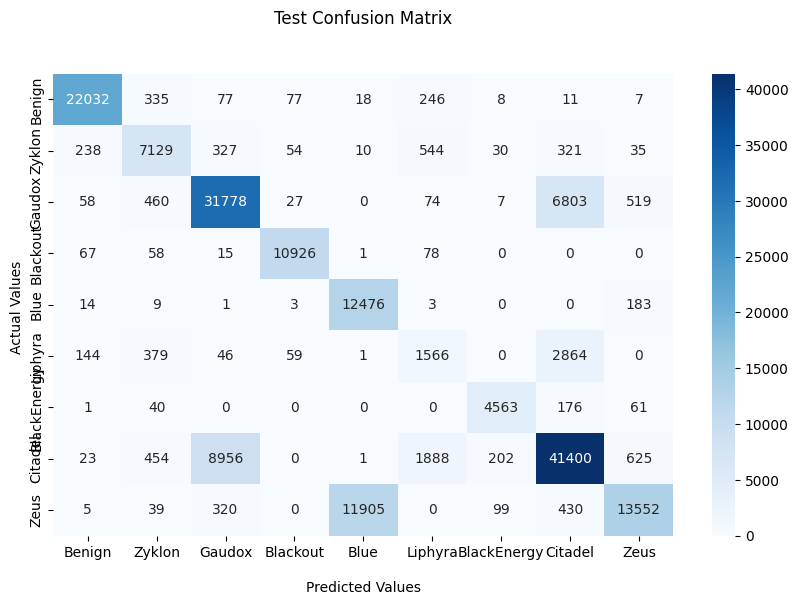

              precision    recall  f1-score   support

      Benign       0.98      0.97      0.97     22811
 BlackEnergy       0.93      0.94      0.94      4841
    Blackout       0.98      0.98      0.98     11145
        Blue       0.51      0.98      0.67     12689
     Citadel       0.80      0.77      0.78     53549
      Gaudox       0.77      0.80      0.78     39726
     Liphyra       0.36      0.31      0.33      5059
        Zeus       0.90      0.51      0.66     26350
      Zyklon       0.80      0.82      0.81      8688

    accuracy                           0.79    184858
   macro avg       0.78      0.79      0.77    184858
weighted avg       0.81      0.79      0.79    184858



In [29]:
param_grid = {
    'max_depth': [5, 10, 30, 50],
    'min_samples_split': [2, 6],
    'criterion': ['gini','entropy'],
    'min_samples_leaf': [1, 4]
}

dtree = DecisionTreeClassifier()

perform_mc_grid_search(dtree, param_grid, df_X_mc, df_y_mc, smote=True)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=6; total time=  17.6s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=1, min_samples_split=2; total time=  25.2s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=4, min_samples_split=6; total time=  23.8s
[CV] END criterion=gini, max_depth=50, min_samples_leaf=4, min_samples_split=2; total time=  23.9s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=2; total time=  12.9s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=6; total time=  19.5s
[CV] END criterion=entropy, max_depth=30, min_samples_leaf=1, min_samples_split=2; total time=  26.7s
[CV] END criterion=entropy, max_depth=30, min_samples_leaf=4, min_samples_split=6; total time=  26.1s
[CV] END criterion=entropy, max_depth=50, min_samples_leaf=4, min_samples_split=6; total time=  19.7s
[CV] END criterion=entropy, max_de

/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=6; total time=  11.6s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=2; total time=  17.2s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=4, min_samples_split=2; total time=  24.4s
[CV] END criterion=gini, max_depth=50, min_samples_leaf=1, min_samples_split=6; total time=  24.5s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=  12.7s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=6; total time=  13.0s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=  19.6s
[CV] END criterion=entropy, max_depth=30, min_samples_leaf=1, min_samples_split=2; total time=  26.9s
[CV] END criterion=entropy, max_depth=30, min_samples_leaf=4, min_samples_split=6; total time=  26.1s
[CV] END criterion=entropy, max_depth=50, min_samples_leaf=4, min_samples_split=2; total time=  2

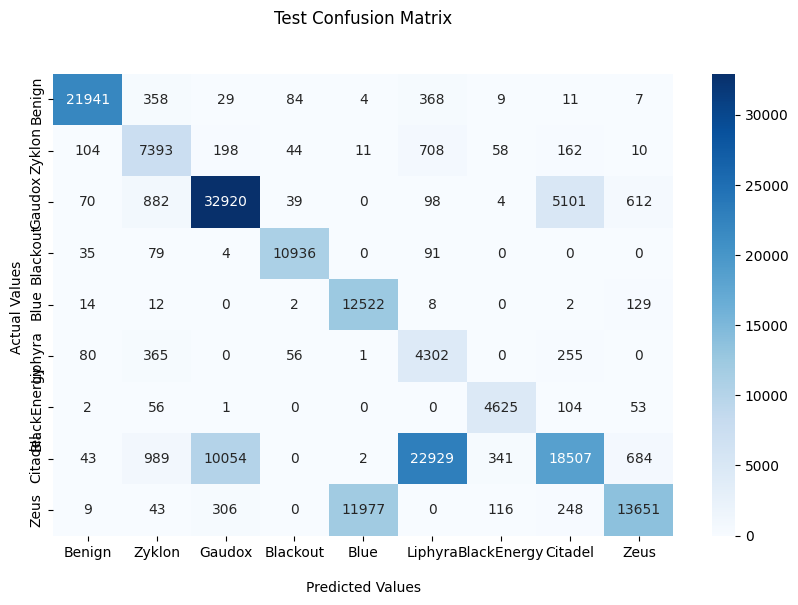

              precision    recall  f1-score   support

      Benign       0.98      0.96      0.97     22811
 BlackEnergy       0.90      0.96      0.93      4841
    Blackout       0.98      0.98      0.98     11145
        Blue       0.51      0.99      0.67     12689
     Citadel       0.76      0.35      0.47     53549
      Gaudox       0.76      0.83      0.79     39726
     Liphyra       0.15      0.85      0.26      5059
        Zeus       0.90      0.52      0.66     26350
      Zyklon       0.73      0.85      0.78      8688

    accuracy                           0.69    184858
   macro avg       0.74      0.81      0.72    184858
weighted avg       0.79      0.69      0.69    184858



In [30]:
param_grid = {
    'max_depth': [5, 10, 30],
    'min_samples_split': [2, 6],
    'criterion': ['entropy'],
    'min_samples_leaf': [1, 4]
}

dtree = DecisionTreeClassifier(class_weight='balanced')

perform_mc_grid_search(dtree, param_grid, df_X_mc, df_y_mc)

#### Random Forest (Multi-Class)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=  17.4s
[CV] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=6; total time=  16.9s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=4, min_samples_split=2; total time=  23.3s
[CV] END criterion=gini, max_depth=50, min_samples_leaf=1, min_samples_split=6; total time=  24.5s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=2; total time=  13.2s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=6; total time=  13.2s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=4, min_samples_split=6; total time=  19.4s
[CV] END criterion=entropy, max_depth=30, min_samples_leaf=4, min_samples_split=2; total time=  26.2s
[CV] END criterion=entropy, max_depth=50, min_samples_leaf=1, min_samples_split=6; total time=  27.3s
[CV] END criterion=entropy, max_dept

/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=  17.5s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=1, min_samples_split=2; total time=  24.9s
[CV] END criterion=gini, max_depth=30, min_samples_leaf=4, min_samples_split=6; total time=  23.9s
[CV] END criterion=gini, max_depth=50, min_samples_leaf=4, min_samples_split=2; total time=  24.0s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=2; total time=  13.4s
[CV] END criterion=entropy, max_depth=10, min_samples_leaf=1, min_samples_split=6; total time=  19.3s
[CV] END criterion=entropy, max_depth=30, min_samples_leaf=1, min_samples_split=2; total time=  27.1s
[CV] END criterion=entropy, max_depth=50, min_samples_leaf=1, min_samples_split=2; total time=  27.7s
[CV] END criterion=entropy, max_depth=50, min_samples_leaf=4, min_samples_split=6; total time=  18.6s
[CV] END criterion=entropy, max_depth=5, min_samples_leaf=1, min_samples_split=6; total time=  

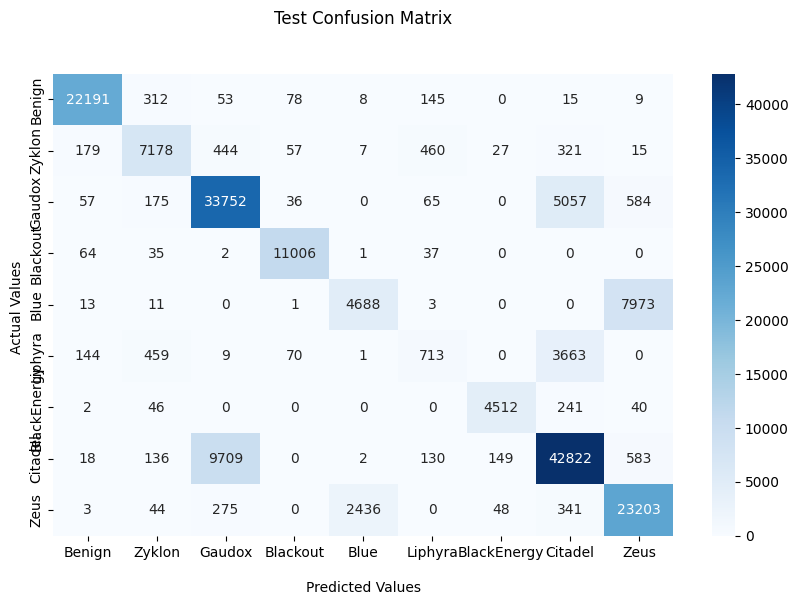

              precision    recall  f1-score   support

      Benign       0.98      0.97      0.98     22811
 BlackEnergy       0.95      0.93      0.94      4841
    Blackout       0.98      0.99      0.98     11145
        Blue       0.66      0.37      0.47     12689
     Citadel       0.82      0.80      0.81     53549
      Gaudox       0.76      0.85      0.80     39726
     Liphyra       0.46      0.14      0.22      5059
        Zeus       0.72      0.88      0.79     26350
      Zyklon       0.85      0.83      0.84      8688

    accuracy                           0.81    184858
   macro avg       0.80      0.75      0.76    184858
weighted avg       0.80      0.81      0.80    184858



In [31]:
param_grid = {
    'max_depth': [5, 10, 30],
    'n_estimators': [50, 100],
    'criterion': ['entropy'],
}


rforest = RandomForestClassifier()

perform_mc_grid_search(rforest, param_grid, df_X_mc, df_y_mc)

Class Frequencies before Upsampling
Label
Citadel        124368
Gaudox          92287
Zeus            61587
Benign          53667
Blue            29865
Blackout        26278
Zyklon          20135
Liphyra         12158
BlackEnergy     10990
Name: count, dtype: int64
Class Frequencies after Upsampling
Label
Citadel        124368
Gaudox          92287
Zeus            61587
Benign          53667
Blackout        50000
Blue            50000
Liphyra         50000
Zyklon          50000
BlackEnergy     50000
Name: count, dtype: int64
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ..criterion=entropy, max_depth=10, n_estimators=100; total time= 2.5min
[CV] END ...criterion=entropy, max_depth=10, n_estimators=50; total time= 1.8min


/Users/bernhardzosel/.pyenv/versions/3.9.7/envs/cysecml_397/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ....criterion=entropy, max_depth=5, n_estimators=50; total time= 1.2min
[CV] END ...criterion=entropy, max_depth=30, n_estimators=50; total time= 2.5min
[CV] END ...criterion=entropy, max_depth=10, n_estimators=50; total time= 1.8min
[CV] END ...criterion=entropy, max_depth=30, n_estimators=50; total time= 2.4min
[CV] END ...criterion=entropy, max_depth=10, n_estimators=50; total time= 1.9min
[CV] END ...criterion=entropy, max_depth=30, n_estimators=50; total time= 2.4min
[CV] END ...criterion=entropy, max_depth=10, n_estimators=50; total time= 1.9min
[CV] END ...criterion=entropy, max_depth=30, n_estimators=50; total time= 2.4min
[CV] END ...criterion=entropy, max_depth=10, n_estimators=50; total time= 1.9min
[CV] END ..criterion=entropy, max_depth=30, n_estimators=100; total time= 3.6min
[CV] END ...criterion=entropy, max_depth=30, n_estimators=50; total time= 2.0min
[CV] END ...criterion=entropy, max_depth=5, n_estimators=100; total time= 2.2min
[CV] END ..criterion=entropy

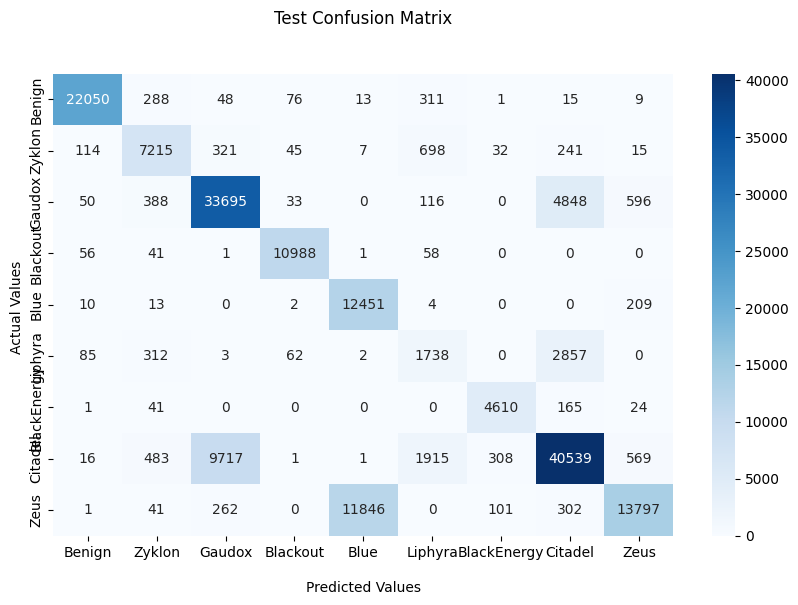

              precision    recall  f1-score   support

      Benign       0.99      0.97      0.98     22811
 BlackEnergy       0.91      0.95      0.93      4841
    Blackout       0.98      0.99      0.98     11145
        Blue       0.51      0.98      0.67     12689
     Citadel       0.83      0.76      0.79     53549
      Gaudox       0.76      0.85      0.80     39726
     Liphyra       0.36      0.34      0.35      5059
        Zeus       0.91      0.52      0.66     26350
      Zyklon       0.82      0.83      0.82      8688

    accuracy                           0.80    184858
   macro avg       0.79      0.80      0.78    184858
weighted avg       0.82      0.80      0.80    184858

[CV] END ...criterion=entropy, max_depth=30, n_estimators=50; total time= 2.4min
[CV] END ...criterion=entropy, max_depth=30, n_estimators=50; total time= 1.8min
[CV] END ....criterion=entropy, max_depth=5, n_estimators=50; total time= 1.2min
[CV] END ..criterion=entropy, max_depth=10, n_estima

In [32]:
param_grid = {
    'max_depth': [5, 10, 30],
    'n_estimators': [50, 100],
    'criterion': ['entropy'],
}


rforest = RandomForestClassifier()

perform_mc_grid_search(rforest, param_grid, df_X_mc, df_y_mc, smote=True)

#### XGBoost (Multi-Class)

*(we experimented with different depths but 8 appeared to be most optimal)*

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df_X_mc, df_y_mc, test_size=0.3, random_state=42)

In [37]:
clf = xgb.XGBClassifier(objective='multi:softmax', num_class=9, eval_metric='mlogloss',max_depth=8)

encoder = LabelEncoder()

# Data as Numpy
X_train = X_train.astype('float32').to_numpy()
X_test = X_test.astype('float32').to_numpy()

# Training the model
clf.fit(X_train, encoder.fit_transform(y_train))

# Evaluating the model
print(f"training accuracy:{clf.score(X_train, encoder.transform(y_train))}")
print(f"test accuracy: {clf.score(X_test, encoder.transform(y_test))}")

training accuracy:0.838983620619704
test accuracy: 0.8168377890056151


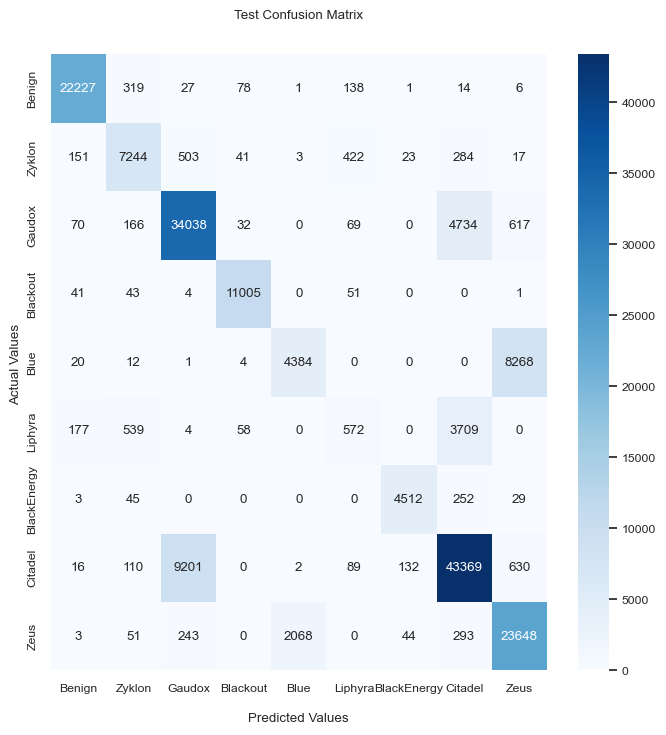

              precision    recall  f1-score   support

      Benign       0.98      0.97      0.98     22811
 BlackEnergy       0.96      0.93      0.94      4841
    Blackout       0.98      0.99      0.98     11145
        Blue       0.68      0.35      0.46     12689
     Citadel       0.82      0.81      0.82     53549
      Gaudox       0.77      0.86      0.81     39726
     Liphyra       0.43      0.11      0.18      5059
        Zeus       0.71      0.90      0.79     26350
      Zyklon       0.85      0.83      0.84      8688

    accuracy                           0.82    184858
   macro avg       0.80      0.75      0.76    184858
weighted avg       0.81      0.82      0.80    184858



In [39]:
unique_labels = ['Benign', 'Zyklon', 'Gaudox', 'Blackout', 'Blue', 'Liphyra','BlackEnergy', 'Citadel', 'Zeus']

y_test_pred = encoder.inverse_transform(clf.predict(X_test))

cm = confusion_matrix(y_test, y_test_pred, labels=unique_labels)    
plt.figure(figsize=(8,8))
sb.set(font_scale=0.8)
ax = sb.heatmap(cm, annot=True, cmap="Blues", fmt='d')
ax.set_title("Test Confusion Matrix\n\n")
ax.set_xlabel("\nPredicted Values")
ax.set_ylabel("Actual Values ")
ax.xaxis.set_ticklabels(unique_labels)
ax.yaxis.set_ticklabels(unique_labels)
plt.show()

print(classification_report(y_test, y_test_pred))

In [40]:
smote = SMOTE(k_neighbors=2, sampling_strategy={'Blue': 50000, 'Blackout': 50000, 'Liphyra':50000, 'BlackEnergy':50000, 'Zyklon':50000})
df_X_mc_smote, df_y_mc_smote = smote.fit_resample(df_X_mc, df_y_mc)

X_train, X_test, y_train, y_test = train_test_split(df_X_mc_smote, df_y_mc_smote, test_size=0.3, random_state=42)

clf = xgb.XGBClassifier(objective='multi:softmax', num_class=9, eval_metric='mlogloss',max_depth=8)

encoder = LabelEncoder()

# Data as Numpy
X_train = X_train.astype('float32').to_numpy()
X_test = X_test.astype('float32').to_numpy()

# Training the model
clf.fit(X_train, encoder.fit_transform(y_train))

# Evaluating the model
print(f"training accuracy:{clf.score(X_train, encoder.transform(y_train))}")
print(f"test accuracy: {clf.score(X_test, encoder.transform(y_test))}")

training accuracy:0.8222116160231618
test accuracy: 0.8019272539852005


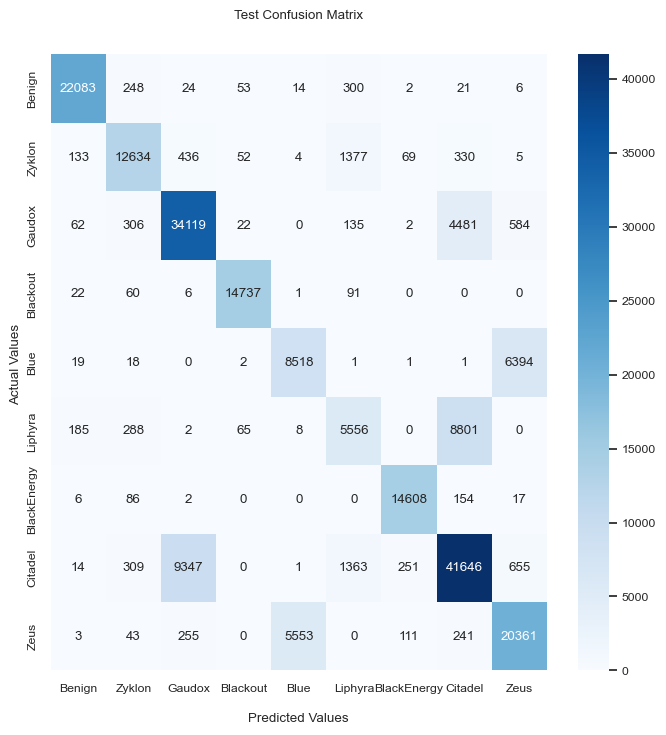

              precision    recall  f1-score   support

      Benign       0.98      0.97      0.98     22751
 BlackEnergy       0.97      0.98      0.98     14873
    Blackout       0.99      0.99      0.99     14917
        Blue       0.60      0.57      0.59     14954
     Citadel       0.75      0.78      0.76     53586
      Gaudox       0.77      0.86      0.81     39711
     Liphyra       0.63      0.37      0.47     14905
        Zeus       0.73      0.77      0.75     26567
      Zyklon       0.90      0.84      0.87     15040

    accuracy                           0.80    217304
   macro avg       0.81      0.79      0.80    217304
weighted avg       0.80      0.80      0.80    217304



In [41]:
unique_labels = ['Benign', 'Zyklon', 'Gaudox', 'Blackout', 'Blue', 'Liphyra','BlackEnergy', 'Citadel', 'Zeus']

y_test_pred = encoder.inverse_transform(clf.predict(X_test))

cm = confusion_matrix(y_test, y_test_pred, labels=unique_labels)    
plt.figure(figsize=(8,8))
sb.set(font_scale=0.8)
ax = sb.heatmap(cm, annot=True, cmap="Blues", fmt='d')
ax.set_title("Test Confusion Matrix\n\n")
ax.set_xlabel("\nPredicted Values")
ax.set_ylabel("Actual Values ")
ax.xaxis.set_ticklabels(unique_labels)
ax.yaxis.set_ticklabels(unique_labels)
plt.show()

print(classification_report(y_test, y_test_pred))

#### Keras Model (Multi-Class)

In [43]:
# Normalize data (not for decision tree and random forest)
scaler = StandardScaler()
df_X_mc_scaled = scaler.fit_transform(df_X_mc[df_X_mc.columns[:-3]])

df_X_mc_scaled = pd.DataFrame(df_X_mc_scaled, columns=df_X_mc.columns[:-3])
df_X_mc_scaled[df_X_mc.columns[-3:]] = df_X_mc[df_X_mc.columns[-3:]]
df_X_mc_scaled.head()

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Protocol_0,Protocol_6,Protocol_17
0,-0.197223,-0.178273,0.061675,-0.256793,-0.012647,0.453814,0.466711,0.464425,-0.046834,-0.276854,...,-0.061106,-0.14495,-0.16014,-0.205001,-0.088995,-0.207219,-0.195185,False,False,True
1,2.427070,0.098283,-0.459456,1.086011,-0.006000,3.311558,3.383699,3.373460,-0.046834,0.047440,...,-0.061106,-0.14495,-0.16014,2.993699,-0.085403,2.569671,3.202846,False,False,True
2,0.084537,0.651396,0.061675,0.504711,-0.011539,0.601121,0.617071,0.614375,-0.046834,-0.260138,...,-0.061106,-0.14495,-0.16014,-0.205001,-0.088995,-0.207219,-0.195185,False,False,True
3,-0.009236,0.651396,-0.459456,0.551215,-0.015971,0.660043,0.677215,0.674355,-0.046834,-0.253452,...,-0.061106,-0.14495,-0.16014,-0.205001,-0.088995,-0.207219,-0.195185,False,False,True
4,0.084535,0.098283,0.061675,0.039670,-0.011096,0.660043,0.677215,0.674355,-0.046834,-0.253452,...,-0.061106,-0.14495,-0.16014,-0.205001,-0.088995,-0.207219,-0.195185,False,False,True


In [44]:
X_train, X_test, y_train, y_test = train_test_split(df_X_mc_scaled, df_y_mc, test_size=0.3)

In [45]:
model = Sequential()
model.add(Dense(64, input_dim=79, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
#model.add(Dense(32, activation='relu'))
model.add(Dense(9, activation='softmax'))

In [46]:
y_train_enc = pd.get_dummies(y_train)
y_train_enc

,Benign,BlackEnergy,Blackout,Blue,Citadel,Gaudox,Liphyra,Zeus,Zyklon
36908,True,False,False,False,False,False,False,False,False
593155,False,False,False,False,True,False,False,False,False
98658,False,False,False,True,False,False,False,False,False
489590,False,False,False,False,True,False,False,False,False
571021,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...
297844,False,False,False,False,False,False,True,False,False
570007,False,False,False,False,False,False,False,True,False
58803,True,False,False,False,False,False,False,False,False
495103,False,False,False,False,True,False,False,False,False


In [47]:
X_train_enc = X_train.astype('float32').to_numpy()
X_train_enc

array([[-0.38322517, -0.45482928,  0.06167462, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.08453711,  0.37483937,  0.06167462, ...,  0.        ,
         0.        ,  1.        ],
       [-0.3838436 , -0.45482928,  0.06167462, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.38364583, -0.45482928,  0.06167462, ...,  0.        ,
         0.        ,  1.        ],
       [-0.38384357, -0.45482928,  0.06167462, ...,  0.        ,
         0.        ,  1.        ],
       [-0.3838435 , -0.45482928,  0.06167462, ...,  0.        ,
         0.        ,  1.        ]], dtype=float32)

In [48]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_enc, y_train_enc, epochs=10, batch_size=32)

Epoch 1/10
13480/13480 [==============================] - 21s 1ms/step - loss: 0.1696 - accuracy: 0.6380
Epoch 2/10
13480/13480 [==============================] - 20s 1ms/step - loss: 0.1287 - accuracy: 0.7190
Epoch 3/10
13480/13480 [==============================] - 20s 2ms/step - loss: 0.1231 - accuracy: 0.7258
Epoch 4/10
13480/13480 [==============================] - 20s 2ms/step - loss: 0.1211 - accuracy: 0.7286
Epoch 5/10
13480/13480 [==============================] - 20s 2ms/step - loss: 0.1220 - accuracy: 0.7253
Epoch 6/10
13480/13480 [==============================] - 21s 2ms/step - loss: 0.1211 - accuracy: 0.7259
Epoch 7/10
13480/13480 [==============================] - 21s 2ms/step - loss: 0.1210 - accuracy: 0.7274
Epoch 8/10
13480/13480 [==============================] - 20s 2ms/step - loss: 0.1213 - accuracy: 0.7276
Epoch 9/10
13480/13480 [==============================] - 21s 2ms/step - loss: 0.1204 - accuracy: 0.7297
Epoch 10/10
13480/13480 [==============================

In [49]:
loss, accuracy = model.evaluate(X_test.astype('float32').to_numpy(), pd.get_dummies(y_test))
print(f"Test Accuracy: {accuracy*100:.2f}%")

5777/5777 [==============================] - 7s 1ms/step - loss: 0.1093 - accuracy: 0.7398
Test Accuracy: 73.98%


#### Bonus: Two-Layered Classifier
**Binary Classification first followed by Multi-class Classification for the malicious case**

*not included in paper, since it does not improve anything (distinguishing malicious and benign classes was not the issue in multi-class classification)*

In [50]:
X_train, X_test, y_botnet_train, y_botnet_test = train_test_split(df_X_mc, df_y_mc, test_size=0.3)

y_binary_train = y_botnet_train.apply(lambda x: 'Malicious' if x != 'Benign' else 'Benign')
y_binary_test = y_botnet_test.apply(lambda x: 'Malicious' if x != 'Benign' else 'Benign')

# Training the first classifier
clf_binary = RandomForestClassifier(max_depth=30)
clf_binary.fit(X_train, y_binary_train)
malicious_indices = (clf_binary.predict(X_train) == 'Malicious')

# Training the second classifier (only on malicious entries)
clf_botnet = RandomForestClassifier(max_depth=30)
clf_botnet.fit(X_train[malicious_indices], y_botnet_train[malicious_indices])

# Predicting on the test set
y_binary_pred = clf_binary.predict(X_test)
print(accuracy_score(y_binary_pred,y_binary_test))

y_botnet_pred = clf_botnet.predict(X_test)

y_test_pred = []

for i, entry in enumerate(y_binary_pred):
    if entry == 'Benign':
        y_test_pred.append('Benign')
    else:
        y_test_pred.append(y_botnet_pred[i])

0.9946499475272912


In [51]:
print(f"Test Accuracy = {accuracy_score(y_test_pred, y_botnet_test)}")

Test Accuracy = 0.8112984020166831
